Q: What's the relationship between AI and ML. What's the relationship betweed deep learning and reinforcement learning? 

A: Check [this link](https://www.forbes.com/sites/bernardmarr/2018/10/22/artificial-intelligence-whats-the-difference-between-deep-learning-and-reinforcement-learning/#4625b44a271e), and [this one](https://www.quora.com/What-are-some-examples-of-artificial-Intelligence-that-are-not-Machine-Learning)

Q: Explain what is the bias-variance tradeoff

A: This describes the performance of a trained model on the test data. An oversimplified model has high bias and low variance (underfitting), whereas an overcomplex model has low bias and high variance (overfitting). This is demonstrated in the image below:
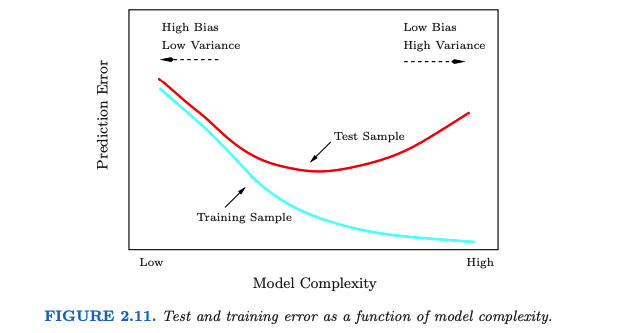
Refer to [this link](http://scott.fortmann-roe.com/docs/BiasVariance.html) for definitions of bias and variance (they are defined per each point). Essentially, bias measures the mean error between the estimation and the actual value, whereas varience measures the spead of the estimation w.r.t. itself. Check [the wiki page](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) as well.
In particular, in this link there's the sentence: "This does not contradict the bias-variance decomposition because the bias-variance decomposition does not imply a bias-variance tradeoff.", where in the first link it has been erroneously implied oppositely. 

Q: Does it apply only to supervised or also to non supervised algorithms?

A: doesn't seem so, since it refers to the error between the actual and estimated values, thus the actual values (i.e. the labels) should exist, which means supervised learning.
On a second thought - even in a non-supervised approach, an over complicated model can create high variance. This is, in fact, demonstrated in [this link](http://scott.fortmann-roe.com/docs/BiasVariance.html). 

Q: How do you distinguish between High variance and High bias when accuracy is insufficient, and how do you improve in either cases? 

A: High bias occurs when the model is oversimplified (not enough features). This will produce the following typical learning curve:
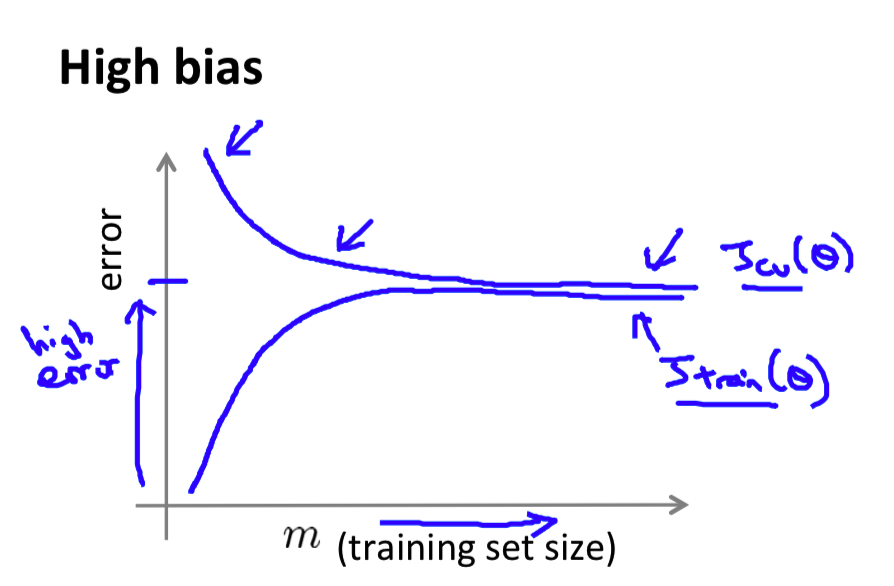
This is since when the model is over simplified, adding more data keeps both the training and cv/test errors similar and high (adding more data doesn't change the simplistic model). The ways to try and improve: 
- Add more features
- Decrease regularization parameter if the features set is sufficiently rich

High variance occurs when he model is over detailed (overfitting). This will produce the following typical learning curve: 
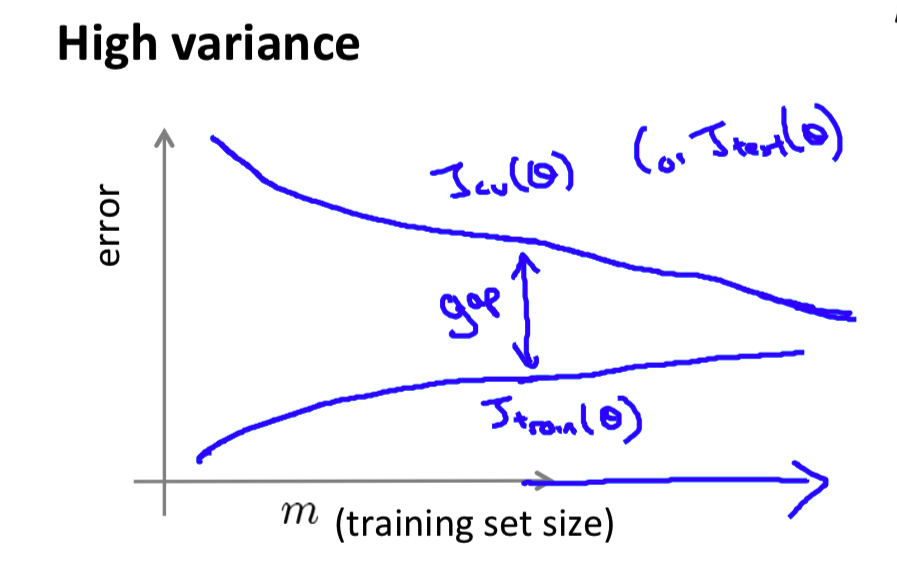
This is by adding more samples the detailed model can eventually compute an estimator which is both specific and accurate. The ways to try and improve: 
- Reduce the number of features or their complexity (e.g. high degree polynomial features)
- Increase the regularization parameter.
- Add more data (more samples)


Q: Explain regularization - both in regression and classification problems

Bias-variance decomposition taken from [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py)

Automatically created module for IPython interactive environment
Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


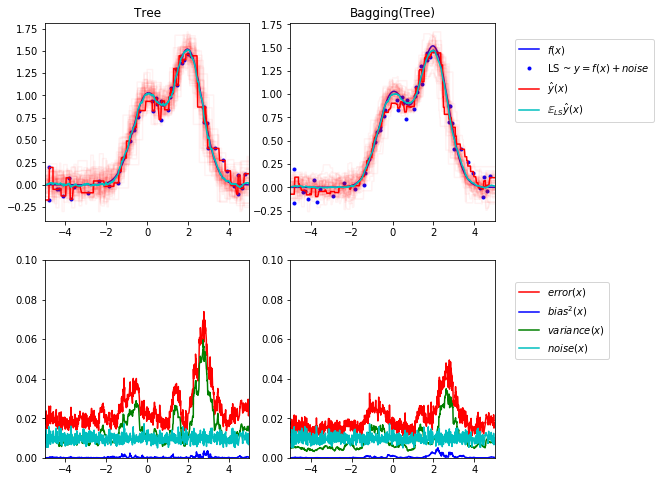

In [1]:
print(__doc__)

# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()